In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
sys.path.append('../training')
from dataLoader import PhotonDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

from matplotlib import pyplot as plt
from scipy import stats

from sklearn.metrics import roc_curve, auc

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


In [2]:
model_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training/models/state_dict_fullbkg.pth'
dataset_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/preprocessing/skim_analyzer_output_reproduce/csv_out/'
test_indices_path = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training/test_indices.npy'
random_seed = 42
### Check CUDA availability
isCUDA = torch.cuda.is_available()

# For reproducibility
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
### load model
from model import net
if isCUDA:
    net = net.cuda()

net.load_state_dict(torch.load(model_path))
net.eval()

### load data and test indices
ds = PhotonDataset(dataset_path, loadIso=True, loadProcess=True)
dataset_size = len(ds)
print("Loading {} events".format(dataset_size))

# Train test split
validation_split = 0.4
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

#test_indices = np.load(test_indices_path) #range(len(ds))#
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(ds, batch_size=10000, sampler=test_sampler)

### Get mean and std
mean, std = ds.calculateMeanAndSigma()
#print("*** MEAN ***\n{}".format(mean))
#print("*** STD ***\n {}".format(std))
mean = torch.from_numpy(np.array(mean)[2:]).float()
std = torch.from_numpy(np.array(std)[2:]).float()

if isCUDA:
    mean = mean.cuda()
    std = std.cuda()

print("Process dict:")
print(ds.processDict)

Merging 24 background files
Merging 52 signal files
Sum weights background : 44.160
Sum weights signal (should be just the length): 54263781.0926782
Reweighting background by 1228794.4334706122
Loading 5574773 events
Process dict:
{'DiPhoton': 1, 'EWK': 2, 'GJet': 3, 'QCD': 4}


In [4]:
### Save mean and std 
save_dir = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/training/'
np.save(save_dir+'mean.npy', mean.cpu().numpy())
np.save(save_dir+'std.npy', std.cpu().numpy())


In [5]:
### evaluate model performance on the data
all_pred = torch.tensor([])
all_label = torch.tensor([])
all_weight = torch.tensor([])
all_iso = torch.tensor([])
all_input = torch.tensor([])
all_fea = torch.tensor([])
all_process = torch.tensor([]).int()

# if isCUDA:
#     all_pred = all_pred.cuda()
#     all_label = all_label.cuda()
#     all_weight = all_weight.cuda()
#     all_iso = all_iso.cuda()
#     all_input = all_input.cuda()
    
for data in test_loader:
    all_features = data['feature'].float()
    label = data['label'].float()
    iso = data['iso'].float()
    process = data['process'].int()
    
    weight = all_features[:, 0] * all_features[:, 1] 
    feature = all_features[:, 2:]
    
    all_input = torch.cat([all_input, feature], 0)
    all_process = torch.cat([all_process, process], 0)
    
    if isCUDA:
        feature = feature.cuda()
        label = label.cuda()
        weight = weight.cuda()
        iso = iso.cuda()
        
        
    
    norm_feature = (feature - mean)/std
    pred = net(norm_feature)
    
    all_pred = torch.cat([all_pred, pred.cpu().data], 0)
    all_label = torch.cat([all_label, label.cpu().data], 0)
    all_weight = torch.cat([all_weight, weight.cpu().data], 0)
    all_iso = torch.cat([all_iso, iso.cpu().data], 0)
    all_fea = torch.cat([all_fea, feature.cpu().data], 0)
    
### Convert to numpy
all_pred = all_pred.view_as(all_label).numpy()
all_label = all_label.numpy()
all_weight = all_weight.numpy()
all_iso = all_iso.numpy()
all_input = all_input.numpy()
all_process = all_process.numpy()
all_fea = all_fea.numpy()

(array([4.221080e+05, 0.000000e+00, 1.405059e+06, 0.000000e+00,
        0.000000e+00, 5.635800e+04, 0.000000e+00, 3.455460e+05,
        0.000000e+00, 8.380000e+02]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

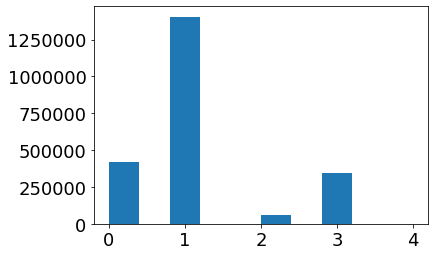

In [6]:
plt.hist(all_process)

In [13]:
all_iso.shape

(2229909, 8)

In [35]:
### Get TPR and FPR with isolation cut
all_signal_weight = all_weight[all_label == 1]
all_signal_isoTight_weight = all_weight[((all_label==1) * (all_iso[:,2]==1) \
                                        * (all_iso[:,3]==1) * (all_iso[:,4]==1) \
                                        * (all_iso[:,5]==1) * (all_iso[:,6]==1) \
                                        * (all_fea[:, -1]<0.4) * (all_iso[:,-1]>70.)) == 1]

tight_TPR = all_signal_isoTight_weight.sum()/all_signal_weight.sum()
print("Tight TPR = {}".format(tight_TPR))

all_signal_isoLoose_weight = all_weight[((all_label==1) * (all_iso[:,2]==1) \
                                        * (all_iso[:,3]==1) * (all_iso[:,4]==1) \
                                        * (all_iso[:,5]==1) * (all_iso[:,6]==1) \
                                        * (all_fea[:, -1]<0.4) * (all_iso[:,-1]>50.)) == 1]
loose_TPR = all_signal_isoLoose_weight.sum()/all_signal_weight.sum()
print("Loose TPR = {}".format(loose_TPR))


all_background_weight = all_weight[all_label == 0]
all_background_isoTight_weight = all_weight[((all_label==0) * (all_iso[:,2]==1) \
                                        * (all_iso[:,3]==1) * (all_iso[:,4]==1) \
                                        * (all_iso[:,5]==1) * (all_iso[:,6]==1) \
                                        * (all_fea[:, -1]<0.4) * (all_iso[:,-1]>70.)) == 1]

tight_FPR = all_background_isoTight_weight.sum()/all_background_weight.sum()
print("Tight FPR = {}".format(tight_FPR))

all_background_isoLoose_weight = all_weight[((all_label==0) * (all_iso[:,2]==1) \
                                        * (all_iso[:,3]==1) * (all_iso[:,4]==1) \
                                        * (all_iso[:,5]==1) * (all_iso[:,6]==1) \
                                        * (all_fea[:, -1]<0.4) * (all_iso[:,-1]>50.)) == 1]
loose_FPR = all_background_isoLoose_weight.sum()/all_background_weight.sum()
print("Loose FPR = {}".format(loose_FPR))

Tight TPR = 0.7910836935043335
Loose TPR = 0.796506404876709
Tight FPR = 0.32171669602394104
Loose FPR = 0.5704326629638672


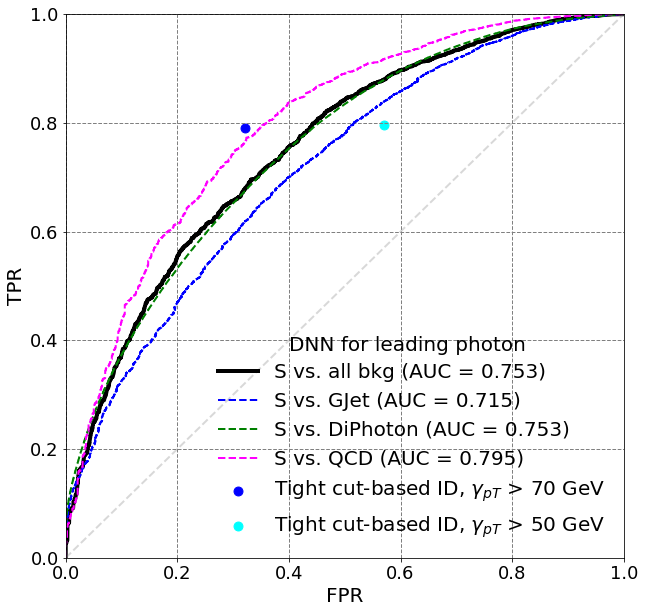

In [36]:
### ROC curve
#### All backgrounds
fpr, tpr, thresholds = roc_curve(all_label[all_iso[:,-1]>70.], all_pred[all_iso[:,-1]>70.], 
                                 sample_weight=all_weight[all_iso[:,-1]>70])
sort_idx = np.argsort(fpr)
tpr_sort, fpr_sort, thresholds_sort = tpr[sort_idx], fpr[sort_idx], thresholds[sort_idx]
roc_auc = auc(fpr_sort, tpr_sort)

#### Signal vs. GJets
selected = (all_process == 2) | (all_process == 0)
fpr_gjets, tpr_gjets, thresholds_gjets = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_weight[selected])
sort_idx = np.argsort(fpr_gjets)
tpr_sort_gjets, fpr_sort_gjets, thresholds_sort_gjets = tpr_gjets[sort_idx], fpr_gjets[sort_idx], thresholds_gjets[sort_idx]
roc_auc_gjets = auc(fpr_sort_gjets, tpr_sort_gjets)

#### Signal vs. DiPhoton
selected = (all_process == 1) | (all_process == 0)
fpr_dipho, tpr_dipho, thresholds_dipho = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_weight[selected])
sort_idx = np.argsort(fpr_dipho)
tpr_sort_dipho, fpr_sort_dipho, thresholds_sort_dipho = tpr_dipho[sort_idx], fpr_dipho[sort_idx], thresholds_dipho[sort_idx]
roc_auc_dipho = auc(fpr_sort_dipho, tpr_sort_dipho)

#### Signal vs. QCD
selected = (all_process == 4) | (all_process == 0)
fpr_qcd, tpr_qcd, thresholds_qcd = roc_curve(all_label[selected], 
                                                   all_pred[selected], 
                                                   sample_weight=all_weight[selected])
sort_idx = np.argsort(fpr_qcd)
tpr_sort_qcd, fpr_sort_qcd, thresholds_sort_qcd = tpr_qcd[sort_idx], fpr_qcd[sort_idx], thresholds_qcd[sort_idx]
roc_auc_qcd = auc(fpr_sort_qcd, tpr_sort_qcd)


fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot()
ax2.plot(fpr, tpr, lw=4, color='black', label='S vs. all bkg (AUC = %.3f)' % (roc_auc))
ax2.plot(fpr_gjets, tpr_gjets, lw=2, linestyle='--', color='blue', label='S vs. GJet (AUC = %.3f)' % (roc_auc_gjets))
ax2.plot(fpr_dipho, tpr_dipho, lw=2, linestyle='--', color='green', label='S vs. DiPhoton (AUC = %.3f)' % (roc_auc_dipho))
ax2.plot(fpr_qcd, tpr_qcd, lw=2, linestyle='--', color='magenta', label='S vs. QCD (AUC = %.3f)' % (roc_auc_qcd))

ax2.scatter(tight_FPR, tight_TPR, s=80, c='blue', label='Tight cut-based ID, $\gamma_{pT}$ > 70 GeV')
ax2.scatter(loose_FPR, loose_TPR, s=80, c='cyan', label='Tight cut-based ID, $\gamma_{pT}$ > 50 GeV')
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.3)
ax2.set_xlim([0, 1.0])
ax2.set_ylim([0, 1.0])
ax2.set_xlabel('FPR', fontsize=20)
ax2.set_ylabel('TPR', fontsize=20)
ax2.legend(loc="lower right", fontsize=20, frameon=0)
ax2.grid(color='grey', linestyle='--', linewidth=1)
ax2.text(0.4, 0.38, "DNN for leading photon", fontsize=20)
plt.show()

In [ ]:
### Assuming choose WP FPR = 
wp = np.argmax(fpr_sort > 0.67)
print("Working point index = {}".format(wp))
dnn_fpr = fpr_sort[wp]
dnn_tpr = tpr_sort[wp]
dnn_thres = thresholds_sort[wp]
print("Threshold = {} @ TPR = {}, FPR = {}".format(dnn_thres, dnn_tpr, dnn_fpr))

In [ ]:
feature_names = ['pho1ecalPFClusterIso','pho1hcalPFClusterIso',
                 'pho1trkSumPtHollowConeDR03','pho1R9',
                 'pho1SigmaIetaIeta','pho1Smajor','pho1Sminor']

feature_df = pd.DataFrame(data=all_input,
                         columns=feature_names)

feature_df['isSignal'] = all_label
feature_df['weight'] = all_weight
feature_df['pred'] = all_pred
feature_df['process'] = all_process
feature_df['isoLoose'] = all_iso[:,0]
feature_df['isoTight'] = all_iso[:,2]
feature_df.head()

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(17, 8))
xranges = {'pho1ecalPFClusterIso': (0,2),
           'pho1hcalPFClusterIso': (0, 2),
           'pho1trkSumPtHollowConeDR03': (0,1),
           'pho1R9': (0,1.),
           'pho1SigmaIetaIeta': (0, 0.04),
           'pho1Smajor': (0, 1.5),
           'pho1Sminor': (0, 0.5)
}

kwarg_plot = {'bins': 40,
              'density': True,
              'alpha': 0.3
              }

idx = 0

label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

for row in range(2):
    for col in range(4):
        if idx >= len(feature_names): continue
        to_plot = feature_names[idx]
        idx += 1
        ax[row, col].hist(feature_df[to_plot][feature_df['isSignal']==1], 
                          weights = feature_df['weight'][feature_df['isSignal']==1],
                          label='Signal', range = xranges[to_plot],
                          color='r',
                          **kwarg_plot)
        ax[row, col].hist(feature_df[to_plot][feature_df['isSignal']==0], 
                          weights = feature_df['weight'][feature_df['isSignal']==0],
                          label='Background', range = xranges[to_plot],
                          color='b',
                          **kwarg_plot)
        
        ax[row, col].set_xlabel(to_plot, fontsize=12)

# The last cell is for legend
ax[1,3].set_axis_off()
ax[1,3].hist([1,1], label='Signal', color='r', alpha=0.3)
ax[1,3].hist([1,1], label='Background', color='b', alpha=0.3)
ax[1,3].legend(loc='center', fontsize=17)
ax[1,3].hist([1,1], color='w')

#ax[1,3].get_yaxis().set_visible(False)


In [ ]:
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


smajor_bkg = feature_df['pho1Smajor'][feature_df['isSignal']==0]
sminor_bkg = feature_df['pho1Sminor'][feature_df['isSignal']==0]
weight_bkg = feature_df['weight'][feature_df['isSignal']==0]
smajor_signal = feature_df['pho1Smajor'][feature_df['isSignal']==1]
sminor_signal = feature_df['pho1Sminor'][feature_df['isSignal']==1]
weight_signal = feature_df['weight'][feature_df['isSignal']==1]


smajor_bkg_selected = feature_df['pho1Smajor'][(feature_df['isSignal']==0) & (feature_df['pred']>dnn_thres)]
sminor_bkg_selected = feature_df['pho1Sminor'][(feature_df['isSignal']==0) & (feature_df['pred']>dnn_thres)]
weight_bkg_selected = feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['pred']>dnn_thres)]

smajor_signal_selected = feature_df['pho1Smajor'][(feature_df['isSignal']==1) & (feature_df['pred']>dnn_thres)]
sminor_signal_selected = feature_df['pho1Sminor'][(feature_df['isSignal']==1) & (feature_df['pred']>dnn_thres)]
weight_signal_selected = feature_df['weight'][(feature_df['isSignal']==1) & (feature_df['pred']>dnn_thres)]


from matplotlib.colors import LogNorm
fig, ax = plt.subplots(2, 2, figsize=(15,12))

chist = ax[0,0].hist2d(smajor_bkg, sminor_bkg, bins=100, 
           weights=weight_bkg, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Blues', alpha=0.5)
fig.colorbar(chist[3], ax=ax[0,0], aspect=40)
ax[0,0].plot([1.3, 1.3], [0, 0.5], lw=4)

chist = ax[1,0].hist2d(smajor_bkg_selected, sminor_bkg_selected, bins=100, 
           weights=weight_bkg_selected, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Purples', alpha=0.5)
fig.colorbar(chist[3], ax=ax[1,0], aspect=40)

chist = ax[0,1].hist2d(smajor_signal, sminor_signal, bins=100, 
           weights=weight_signal, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Reds', alpha=0.5)
fig.colorbar(chist[3], ax=ax[0, 1], aspect=40)
ax[0,1].plot([1.3, 1.3], [0, 0.5], lw=4, c='r')


chist = ax[1,1].hist2d(smajor_signal_selected, sminor_signal_selected, bins=100, 
           weights=weight_signal_selected, range=((0,1.5),(0.,0.5)), 
           norm=LogNorm(), cmap='Purples', alpha=0.5)
fig.colorbar(chist[3], ax=ax[1,1], aspect=40)

for i in (0, 1):
    for j in (0, 1):
        ax[i, j].set_xlabel('Smajor',fontsize=20)
        ax[i, j].set_ylabel('Sminor',fontsize=20)
ax[0,0].set_title('Background', fontsize=20)
ax[0,1].set_title('Signal', fontsize=20)
ax[1,0].set_title('Background DNN Selected', fontsize=20)
ax[1,1].set_title('Signal DNN Selected', fontsize=20)

plt.subplots_adjust(top=0.92, bottom=0.08, 
                    left=0.10, right=0.9, 
                    hspace=0.3, wspace=0.3)

ax[0,0].text(1.2, 0.25, '2016 cut-based threshold',
         rotation=90,
         size=18,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center')

ax[0,1].text(1.2, 0.25, '2016 cut-based threshold',
         rotation=90,
         size=18,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center')

In [ ]:
plt.figure(figsize=(8,6))

background = ([feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==1)],
                        feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==2)],
                        feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==3)],
                        feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==4)],
                       ])

background_weight = ([feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==1)],
                        feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==2)],
                        feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==3)],
                        feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==4)]
                       ])

#print(background.shape)
background_label = ['DiPhoton', 'EWK', 'GJet', 'QCD']
background_color = ['green', 'goldenrod', 'blue', 'magenta']
plt.hist(background, 
         bins=100, range=(0,1), stacked=True,
         weights=background_weight,
         label=background_label, color=background_color, alpha=0.8)
plt.hist(feature_df['pred'][feature_df['isSignal']==1], 
         bins=100, range=(0,1),
         weights=feature_df['weight'][feature_df['isSignal']==1],
         label='Signal', color='black', alpha=1, histtype='step',
         linewidth=3)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=18)
plt.xlabel('DNN Prediction Score', fontsize=20)

In [ ]:
plt.hist(feature_df['pred'][(feature_df['isSignal']==0) & (feature_df['process']==4)],
        bins=40, range=(0, 1), 
        weights= feature_df['weight'][(feature_df['isSignal']==0) & (feature_df['process']==4)])